## 5.3 시계열 데이터를 예측하는 LSTM 구현
LSTM을 이용해 시계열 데이터에 대한 예측

In [1]:
# set to use CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

### 5.2.1 라이브러리 패키지 임포트
1. LSTM을 이용한 판별망 구현에 필요한 라이브러리 임포트

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
import seaborn as sns

from keras import models, layers

from keraspp import skeras

### 5.3.2 코드 실행 및 결과 보기
2. 세부 코드를 보기 전에 머신을 만들고 실행하는 부분

In [3]:
def main():    
    machine = Machine() 
    machine.run(epochs=400)

### 5.3.3 학습하고 평가하기
3. 머신 클래스는 시계열 LSTM을 학습하고 평가하는 플랫폼

In [4]:
class Machine():
    def __init__(self):
        self.data = Dataset()
        shape = self.data.X.shape[1:]
        self.model = rnn_model(shape)
        
    def run(self, epochs=400):
        d = self.data
        X_train, X_test, y_train, y_test = d.X_train, d.X_test, d.y_train, d.y_test
        X, y = d.X, d.y
        m = self.model 
        h = m.fit(X_train, y_train, epochs=epochs, validation_data=[X_test, y_test], verbose=0)

        skeras.plot_loss(h)
        plt.title('History of training')
        plt.show()

        yp = m.predict(X_test)
        print('Loss:', m.evaluate(X_test, y_test))
        plt.plot(yp, label='Origial')
        plt.plot(y_test, label='Prediction')
        plt.legend(loc=0)
        plt.title('Validation Results')
        plt.show()

        yp = m.predict(X_test).reshape(-1)
        print('Loss:', m.evaluate(X_test, y_test))  
        print(yp.shape, y_test.shape)

        df = pd.DataFrame()
        df['Sample'] = list(range(len(y_test))) * 2
        df['Normalized #Passengers'] = np.concatenate([y_test, yp], axis=0)
        df['Type'] = ['Original'] * len(y_test) + ['Prediction'] * len(yp)

        plt.figure(figsize=(7, 5))
        sns.barplot(x="Sample", y="Normalized #Passengers", 
                    hue="Type", data=df)
        plt.ylabel('Normalized #Passengers')
        plt.show()
        
        yp = m.predict(X)

        plt.plot(yp, label='Origial')
        plt.plot(y, label='Prediction')
        plt.legend(loc=0)
        plt.title('All Results')
        plt.show()

### 5.3.4 LSTM 시계열 회귀 모델링
4. 시계열 데이터의 회귀 모델링을 위한 LSTM 모델의 구성

In [5]:
def rnn_model(shape):
    m_x = layers.Input(shape=shape) #X.shape[1:]
    m_h = layers.LSTM(10)(m_x)
    m_y = layers.Dense(1)(m_h)
    m = models.Model(m_x, m_y)
    m.compile('adam', 'mean_squared_error')
    m.summary()
    return m

### 5.3.5 데이터 불러오기 
5. 데이터는 Dataset 클래스를 구성해서 불러옴

In [6]:
class Dataset:
    def __init__(self, fname='international-airline-passengers.csv', D=12):
        data_dn = load_data(fname=fname)
        self.X, self.y = get_Xy(data_dn, D=D)
        self.X_train, self.X_test, self.y_train, self.y_test = \
            model_selection.train_test_split(self.X, self.y, 
              test_size=0.2, random_state=42)   

In [7]:
def load_data(fname='international-airline-passengers.csv'):
    dataset = pd.read_csv(fname, usecols=[1], engine='python', skipfooter=3)
    data = dataset.values.reshape(-1)
    plt.plot(data)
    plt.xlabel('Time'); plt.ylabel('#Passengers')
    plt.title('Original Data')
    plt.show()

    # data normalize
    data_dn = (data - np.mean(data)) / np.std(data) / 5
    plt.plot(data_dn)
    plt.xlabel('Time'); plt.ylabel('Normalized #Passengers')
    plt.title('Normalized data by $E[]$ and $5\sigma$')
    plt.show()
    
    return data_dn

In [8]:
def get_Xy(data, D=12):
    # make X and y
    X_l = []
    y_l = []
    N = len(data)
    assert N > D, "N should be larger than D, where N is len(data)"
    for ii in range(N-D-1):
        X_l.append(data[ii:ii+D])
        y_l.append(data[ii+D])
    X = np.array(X_l)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.array(y_l)
    print(X.shape, y.shape)
    return X, y

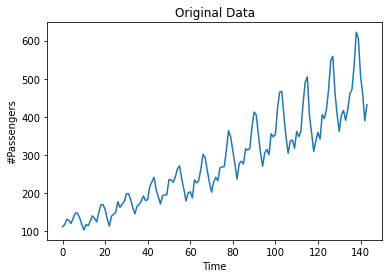

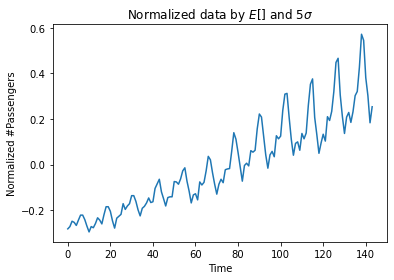

(131, 12, 1) (131,)


2021-10-21 11:09:25.110472: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-21 11:09:25.436532: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-21 11:09:25.436711: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SJKIM-Home): /proc/driver/nvidia/version does not exist
2021-10-21 11:09:25.438667: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-10-21 11:09:25.454581: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3599995000 Hz
2021-10-21 11:09:25.457256: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55729e0c7470 initialized for platform Host (this does not guarantee that XLA will be used). Devi

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


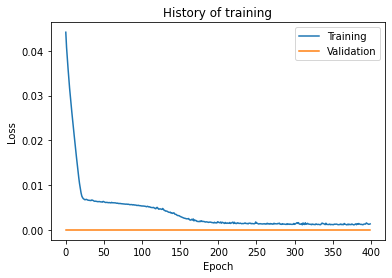

1/1 [==============================] - 0s 1ms/step - loss: 0.0016
Loss: 0.0015872480580583215


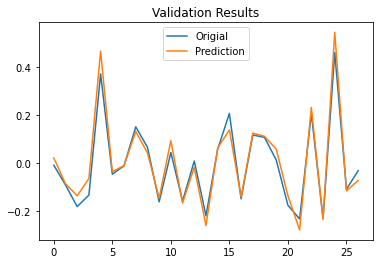

1/1 [==============================] - 0s 2ms/step - loss: 0.0016
Loss: 0.0015872480580583215
(27,) (27,)


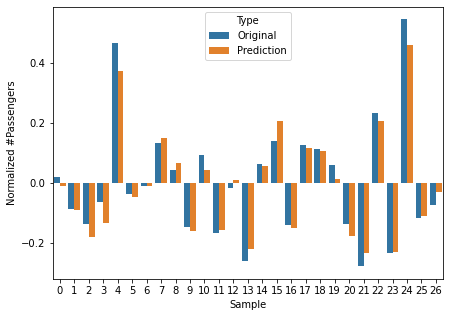

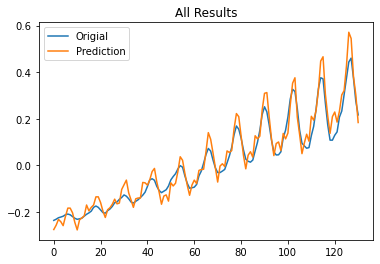

In [9]:
main()

---
### 전체 코드

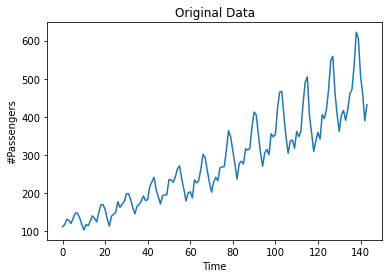

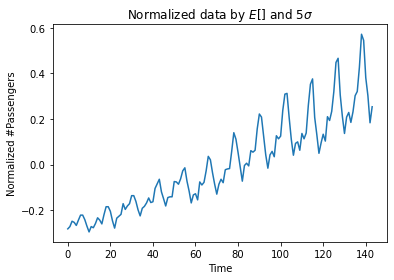

(131, 12, 1) (131,)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


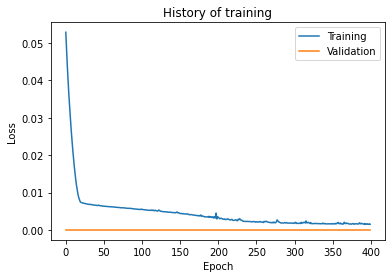

1/1 [==============================] - 0s 2ms/step - loss: 0.0018
Loss: 0.0017508951714262366


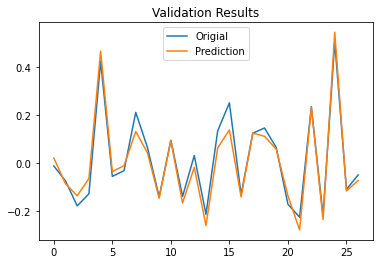

1/1 [==============================] - 0s 1ms/step - loss: 0.0018
Loss: 0.0017508951714262366
(27,) (27,)


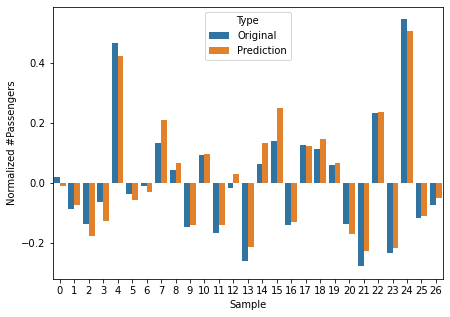

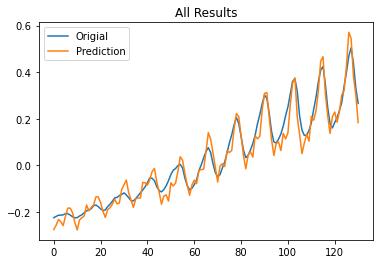

In [11]:
# %% 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from keras import models, layers
import seaborn as sns
from keraspp import skeras

# %%
def main():        
    machine = Machine() 
    machine.run(epochs=400)

class Machine():
    def __init__(self):
        self.data = Dataset()
        shape = self.data.X.shape[1:]
        self.model = rnn_model(shape)
        
    def run(self, epochs=400):
        d = self.data
        X_train, X_test, y_train, y_test = d.X_train, d.X_test, d.y_train, d.y_test
        X, y = d.X, d.y
        m = self.model 
        h = m.fit(X_train, y_train, epochs=epochs, validation_data=[X_test, y_test], verbose=0)

        skeras.plot_loss(h)
        plt.title('History of training')
        plt.show()

        yp = m.predict(X_test)
        print('Loss:', m.evaluate(X_test, y_test))
        plt.plot(yp, label='Origial')
        plt.plot(y_test, label='Prediction')
        plt.legend(loc=0)
        plt.title('Validation Results')
        plt.show()

        yp = m.predict(X_test).reshape(-1)
        print('Loss:', m.evaluate(X_test, y_test))  
        print(yp.shape, y_test.shape)

        df = pd.DataFrame()
        df['Sample'] = list(range(len(y_test))) * 2
        df['Normalized #Passengers'] = np.concatenate([y_test, yp], axis=0)
        df['Type'] = ['Original'] * len(y_test) + ['Prediction'] * len(yp)

        plt.figure(figsize=(7, 5))
        sns.barplot(x="Sample", y="Normalized #Passengers", 
                    hue="Type", data=df)
        plt.ylabel('Normalized #Passengers')
        plt.show()
        
        yp = m.predict(X)

        plt.plot(yp, label='Origial')
        plt.plot(y, label='Prediction')
        plt.legend(loc=0)
        plt.title('All Results')
        plt.show()

def rnn_model(shape):
    m_x = layers.Input(shape=shape) #X.shape[1:]
    m_h = layers.LSTM(10)(m_x)
    m_y = layers.Dense(1)(m_h)
    m = models.Model(m_x, m_y)
    m.compile('adam', 'mean_squared_error')
    m.summary()
    return m

class Dataset:
    def __init__(self, fname='international-airline-passengers.csv', D=12):
        data_dn = load_data(fname=fname)
        self.X, self.y = get_Xy(data_dn, D=D)
        self.X_train, self.X_test, self.y_train, self.y_test = \
           model_selection.train_test_split(self.X, self.y, 
              test_size=0.2, random_state=42)  

def load_data(fname='international-airline-passengers.csv'):
    dataset = pd.read_csv(fname, usecols=[1], engine='python', skipfooter=3)
    data = dataset.values.reshape(-1)
    plt.plot(data)
    plt.xlabel('Time'); plt.ylabel('#Passengers')
    plt.title('Original Data')
    plt.show()

    # data normalize
    data_dn = (data - np.mean(data)) / np.std(data) / 5
    plt.plot(data_dn)
    plt.xlabel('Time'); plt.ylabel('Normalized #Passengers')
    plt.title('Normalized data by $E[]$ and $5\sigma$')
    plt.show()
    
    return data_dn

def get_Xy(data, D=12):
    # make X and y
    X_l = []
    y_l = []
    N = len(data)
    assert N > D, "N should be larger than D, where N is len(data)"
    for ii in range(N-D-1):
        X_l.append(data[ii:ii+D])
        y_l.append(data[ii+D])
    X = np.array(X_l)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.array(y_l)
    print(X.shape, y.shape)
    return X, y

main()